In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import random

# Cluster size feedback efficiency

**The idea:** Implement the cluster size feedback on three different lattices: the Sierpinski carpet lattice, a square lattice and a non-similar random lattice with the same number of spins ($N=4096$).

**Steps:** 
1. Generate the three lattices.
2. Implement the cluster size feedback on each lattice and record the following at each iteration: the number of clusters and the mean size of clusters.
3. Plot each of these values as a function of the distance to the critical temperature for each of the lattices and analyze the differences.

In [2]:
def sierpinski_carpet(lattice, total): #total number of times the process will be repeated  
    for i in range(0, total + 1):
        stepdown = 3**(total - i)
        for x in range(0, 3**i):
          
            # checking for the centremost square
            if x % 3 == 1:
                for y in range(0, 3**i):
                    if y % 3 == 1:
                      
                    # changing its value
                        lattice[y * stepdown:(y + 1)*stepdown, x * stepdown:(x + 1)*stepdown] = 0
                        
    return lattice

In [3]:
def flattice(times):
    
    N= 3**times
    lattice= np.random.choice([-1, 1], size=(N, N))
    flattice= sierpinski_carpet(lattice, times)
    
    return flattice

In [4]:
def create_non_similar_lattice(n, m):
    lattice = np.zeros((n, n), dtype=int)
    
    # Initialize coordinates at the boundary
    boundary_coords = [(0, y) for y in range(n)] + [(n - 1, y) for y in range(n)] + [(x, 0) for x in range(1, n - 1)] + [(x, n - 1) for x in range(1, n - 1)]
    np.random.shuffle(boundary_coords)
    
    spins_assigned = 0  # Keep track of the number of spins assigned
    visited = set()  # Keep track of visited coordinates
    
    def dfs(x, y):
        nonlocal spins_assigned
        if spins_assigned >= m:
            return
        spin = np.random.choice([-1, 1])
        # Assign the spin to the selected coordinate
        lattice[x, y] = spin
        spins_assigned += 1  # Increment the number of spins assigned
        visited.add((x, y))  # Mark the current coordinate as visited
        
        # Define possible neighbor positions
        neighbors = [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]
        
        # Shuffle the order of neighbors randomly
        np.random.shuffle(neighbors)
        
        for nx, ny in neighbors:
            if 0 <= nx < n and 0 <= ny < n and (nx, ny) not in visited:
                # If the neighbor is within bounds and not visited, visit it recursively
                dfs(nx, ny)
    
    # Start the DFS from the boundary positions
    for x, y in boundary_coords:
        dfs(x, y)
    
    return lattice

In [5]:
def calculate_energy(lattice, i, j):
    size = lattice.shape[0]
    
    spin_ij = lattice[i, j]

    neighbors_indices = [((i+1) % size, j), ((i-1+size) % size, j), (i, (j+1) % size), (i, (j-1+size) % size)]


    dE = 0

    for ni, nj in neighbors_indices:
        if 0 <= ni < size and 0 <= nj < size:
            spin_neighbor = lattice[ni, nj]
            dE += 2 * spin_ij * spin_neighbor

    return dE

In [6]:
def metropolis_step(lattice, temperature):
    
    size = lattice.shape[0]
    i, j = random.randint(0, size-1), random.randint(0, size-1)
    
    beta= 1/temperature
    while lattice[i,j] == 0:
        i, j = random.randint(0, size-1), random.randint(0, size-1)
        
    dE = calculate_energy(lattice, i, j)
    
    if (dE > 0) and (np.random.random() < np.exp(-dE*beta)):
        lattice[i, j] *= -1
    elif dE <= 0:
        lattice[i, j] *= -1

In [7]:
def swendsen_wang_step(lattice, type_, times, temperature, r_clusters):
    
    size = lattice.shape[0]
    
    visited = np.full_like(lattice, -1)
    
    if type_ == 0:
        visited = sierpinski_carpet(visited, times)

    elif type_ == 2:
        visited[lattice == 0] = 0
    
        
    clusters = []
    
    # Calculate bond probability based on temperature and coupling constant J

    p = 1.0 - np.exp(-2 /(temperature))

    for i in range(size):
        for j in range(size):
            if visited[i, j] == -1:
                cluster = set()
                stack = [(i, j)]

                while stack:
                    x, y = stack.pop()
                    if visited[x, y] == -1:
                        visited[x, y] = 1
                        cluster.add((x, y))
                        for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                            nx, ny = x + dx, y + dy  # Removed modulo operations for no-periodic boundary conditions
                            if 0 <= nx < size and 0 <= ny < size:  # Check for valid indices within the lattice
                                if visited[nx, ny] == -1 and lattice[x, y] == lattice[nx, ny] and np.random.rand() < p:
                                    stack.append((nx, ny))

                clusters.append(cluster)
    
    for cluster in clusters:
        if random.random() < 0.5:
            for i, j in cluster:
                lattice[i, j] *= -1
                
    if r_clusters == True:  
        return clusters

In [8]:
def combined_metropolis_swendsen_wang(lattice, temperature, type_, times,  m, n):
    for _ in range(m):
        metropolis_step(lattice, temperature)
    for _ in range(n):
        swendsen_wang_step(lattice, type_, times, temperature, False)

In [9]:
def is_infinite_cluster(cluster, type_, times):
    
    min_x = min(coord[0] for coord in cluster)
    max_x = max(coord[0] for coord in cluster)
    min_y = min(coord[1] for coord in cluster)
    max_y = max(coord[1] for coord in cluster)
    
    if type_ == 0 or type_ == 2:
        grid_size = 3**times
        
    elif type_ == 1:
        grid_size = times
    
    if (min_x == 0 and max_x == grid_size - 1) or (min_y == 0 and max_y == grid_size - 1):
        return True
    else:
        return False

In [10]:
def feedback(clusters, dTJ, type_, times):
    i=0
    while i < len(clusters):
        is_infinite = is_infinite_cluster(clusters[i], type_, times)
        if is_infinite == True:
            deltaTJ= dTJ
            break
        else:
            i+=1
            deltaTJ= -dTJ
            
    return deltaTJ

In [11]:
def get_spin_energy_fb(lattice, type_, times):
    
    steps= 100
    ms = np.zeros(steps)
    number_clusters= np.zeros(steps)
    mean_size_cluster= np.zeros(steps)
    cluster_max= np.zeros(steps)
    tjs= np.zeros(steps)

    if type_== 0:
        TJ= TJf_i
    elif type_ == 1:
        TJ= TJc_i
    else:
        TJ= TJns_i
    
    m= 100000
    n= 100
    
    if times== 6 or times==7:
        m=200000
        n=200
    
    for i in tqdm (range(steps), desc="Implementing feedback"):
        combined_metropolis_swendsen_wang(lattice, TJ, type_, times, m, n)
        clusters= swendsen_wang_step(lattice, type_, times, TJ, True)
        ms[i] = lattice.sum()/np.count_nonzero(lattice)
        number_clusters[i]= len(clusters)
        mean_size_cluster[i]= (sum(len(cluster) for cluster in clusters))/len(clusters)
        size_clusters= []
        size_clusters.extend([len(cluster) for cluster in clusters])
        cluster_max[i]= max(size_clusters)
        TJ= TJ+ feedback(clusters, dTJ, type_, times)
        tjs[i]= TJ
    return ms, tjs, number_clusters, mean_size_cluster, cluster_max

In [12]:
lattice1= flattice(4) #Tc= 1.48
lattice2= np.random.choice([-1, 1], size=(64, 64)) #Tc= 2.26

#The non-self-similar lattice is imported
lattice3= np.loadtxt('non_similar_lattice.txt', delimiter=',')

lattices=[lattice1, lattice2, lattice3]

#Parameters that configure the simulations for each geometry

fractal_v=[0, 1, 2]
times=[4,64,4]

In [13]:
TJf_i= 1.0
TJc_i= 1.8
TJns_i = 1.4
dTJ= 0.01

In [14]:
bjf_=[]
ms_=[]
nc_=[]
msc_=[]
bc_=[]
for i in range(len(lattices)):
    ms, bjf, nc, msc, bc= get_spin_energy_fb(lattices[i], fractal_v[i], times[i])
    bjf_.append(bjf)
    ms_.append(ms)
    nc_.append(nc)
    msc_.append(msc)
    bc_.append(bc)

Implementing feedback: 100%|██████████| 100/100 [04:53<00:00,  2.93s/it]


In [15]:
TJf_i= 1.9
TJc_i= 2.7
TJns_i = 2.3
dTJ= 0.01

In [16]:
bjf2_=[]
ms2_=[]
nc2_=[]
msc2_=[]
bc2_=[]
for i in range(len(lattices)):
    ms, bjf, nc, msc, bc= get_spin_energy_fb(lattices[i], fractal_v[i], times[i])
    bjf2_.append(bjf)
    ms2_.append(ms)
    nc2_.append(nc)
    msc2_.append(msc)
    bc2_.append(bc)

Implementing feedback: 100%|██████████| 100/100 [04:50<00:00,  2.91s/it]


In [17]:
ts2= bjf2_.copy()
ts2[0]= 1.48-np.array(ts2[0]) 
ts2[1]= 2.26-np.array(ts2[1])
ts2[2]= 1.86 - np.array(ts2[2])

In [18]:
ts= bjf_.copy()
ts[0]= 1.48-np.array(ts[0])
ts[1]= 2.26-np.array(ts[1])
ts[2]= 1.86-np.array(ts[2])

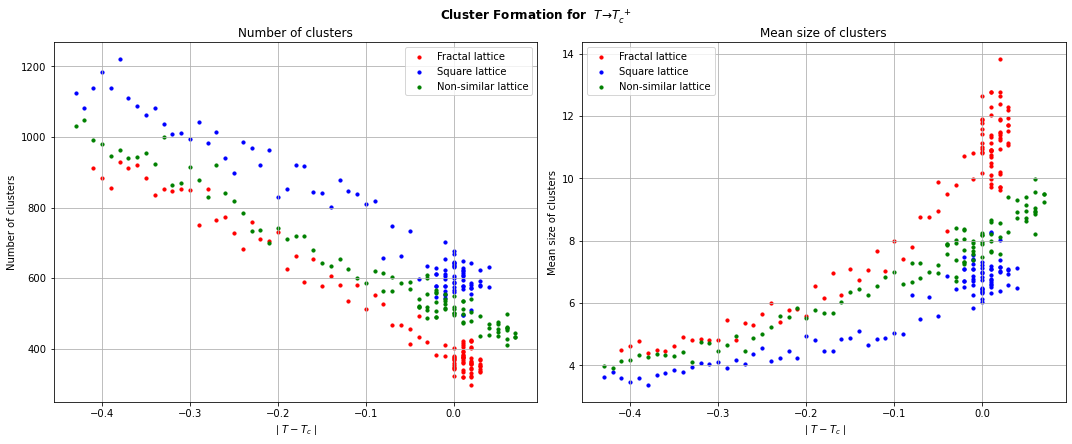

In [19]:
fig= plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.scatter(ts2[0], nc2_[0], label='Fractal lattice', color='red', s=10)
plt.scatter(ts2[1], nc2_[1], label='Square lattice', color='blue', s=10)
plt.scatter(ts2[2], nc2_[2], label='Non-similar lattice', color='green', s=10)
plt.title(r"Number of clusters")
plt.ylabel('Number of clusters')
plt.xlabel('$\mid T - T_c \mid$')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.scatter(ts2[0], msc2_[0], label='Fractal lattice', color='red', s=10)
plt.scatter(ts2[1], msc2_[1], label='Square lattice', color='blue', s=10)
plt.scatter(ts2[2], msc2_[2], label='Non-similar lattice', color='green', s=10)
plt.title(r"Mean size of clusters")
plt.ylabel("Mean size of clusters")
plt.xlabel('$\mid T - T_c \mid$')
plt.grid(True)


plt.tight_layout()  # Ensures proper spacing between subplots
plt.legend() 
fig.suptitle(r'Cluster Formation for $~T \to T_c^{~+}$', y=1.02, fontweight='bold')
plt.show()

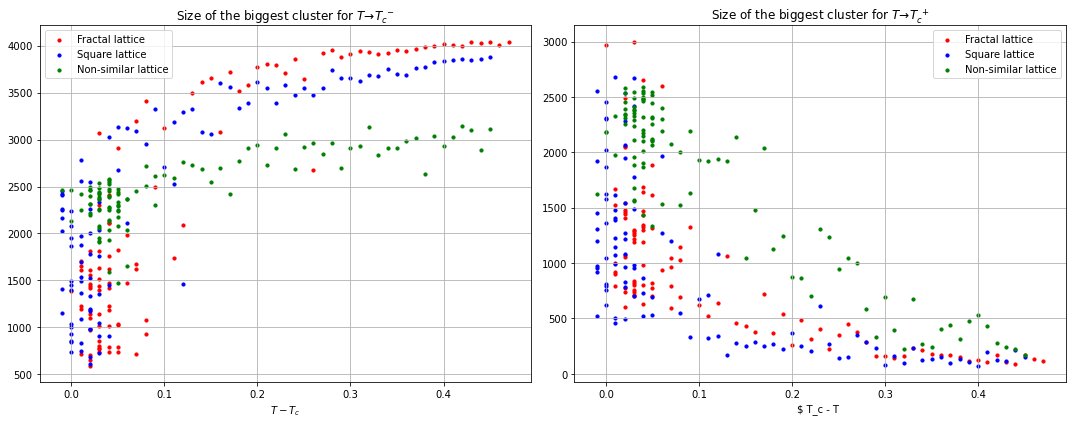

In [20]:
fig= plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.scatter(ts[0], bc_[0], label='Fractal lattice', color='red', s=10)
plt.scatter(ts[1], bc_[1], label='Square lattice', color='blue', s=10)
plt.scatter(ts[2], bc_[2], label='Non-similar lattice', color='green', s=10)
plt.title(r"Size of the biggest cluster for $T \to T_c^{~-}$")
#plt.ylabel()
plt.xlabel('$ T - T_c $')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.scatter(ts[0], bc2_[0], label='Fractal lattice', color='red', s=10)
plt.scatter(ts[1], bc2_[1], label='Square lattice', color='blue', s=10)
plt.scatter(ts[2], bc2_[2], label='Non-similar lattice', color='green', s=10)
plt.title(r"Size of the biggest cluster for $T \to T_c^{~+}$")
#plt.ylabel()
plt.xlabel('$ T_c - T ')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.legend() 
plt.grid(True)

plt.show()

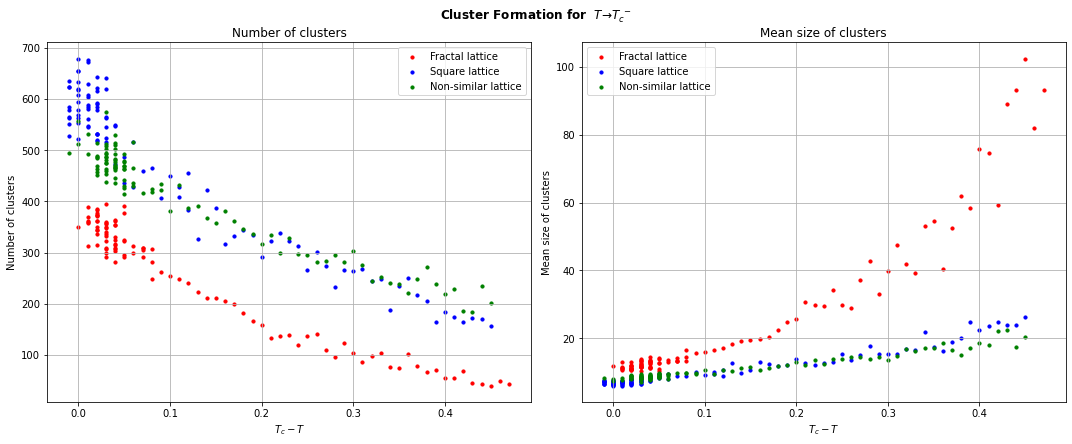

In [21]:
fig= plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.scatter(ts[0], nc_[0], label='Fractal lattice', color='red', s=10)
plt.scatter(ts[1], nc_[1], label='Square lattice', color='blue', s=10)
plt.scatter(ts[2], nc_[2], label='Non-similar lattice', color='green', s=10)
plt.title(r"Number of clusters")
plt.ylabel('Number of clusters')
plt.xlabel('$T_c - T$')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.scatter(ts[0], msc_[0], label='Fractal lattice', color='red', s=10)
plt.scatter(ts[1], msc_[1], label='Square lattice', color='blue', s=10)
plt.scatter(ts[2], msc_[2], label='Non-similar lattice', color='green', s=10)
plt.title(r"Mean size of clusters")
plt.ylabel("Mean size of clusters")
plt.xlabel('$T_c - T$')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.legend() 
fig.suptitle(r'Cluster Formation for $~T \to T_c^{~-}$', y=1.02, fontweight='bold')
plt.grid(True)

plt.show()

## Efficiency

As mentioned earlier, we are working with 3 lattices that have the same number of spins ($N= 4096$). So, to observe the differences in the algorithm's performance, the following quantity is introduced
\begin{align}
\eta&= \frac{MSC}{NC}= \frac{N}{NC^2}
\end{align}


In [22]:
x= ts[0].reshape(-1,1)
y= np.log(np.array(msc_[0])/np.array(nc_[0]))
model1 = LinearRegression()
model1.fit(x, y)
coefficients1 = model1.coef_
print("Coefficient:", coefficients1[0])

Coefficient: 9.192377549436909


In [23]:
x2= ts[1].reshape(-1,1)
y2= np.log(np.array(msc_[1])/np.array(nc_[1]))
model2 = LinearRegression()
model2.fit(x2, y2)
coefficients2 = model2.coef_
print("Coefficient:", coefficients2[0])

Coefficient: 5.8057210015485525


In [24]:
x3= ts[2].reshape(-1,1)
y3= np.log(np.array(msc_[2])/np.array(nc_[2]))
model3 = LinearRegression()
model3.fit(x3, y3)
coefficients3 = model3.coef_
print("Coefficient:", coefficients3[0])

Coefficient: 4.203317248152566


In [25]:
x_= ts2[0].reshape(-1,1)
y_= np.log(np.array(msc2_[0])/np.array(nc2_[0]))
model1_ = LinearRegression()
model1_.fit(x_, y_)
coefficients1_ = model1_.coef_
print("Coefficient:", coefficients1_[0])

Coefficient: 4.961738135009301


In [26]:
x2_= ts2[1].reshape(-1,1)
y2_= np.log(np.array(msc2_[1])/np.array(nc2_[1]))
model2_ = LinearRegression()
model2_.fit(x2_, y2_)
coefficients2_ = model2_.coef_
print("Coefficient:", coefficients2_[0])

Coefficient: 3.3957718392217737


In [27]:
x3_= ts2[2].reshape(-1,1)
y3_= np.log(np.array(msc2_[2])/np.array(nc2_[2]))
model3_ = LinearRegression()
model3_.fit(x3_, y3_)
coefficients3_ = model3_.coef_
print("Coefficient:", coefficients3_[0])

Coefficient: 3.516113814665772


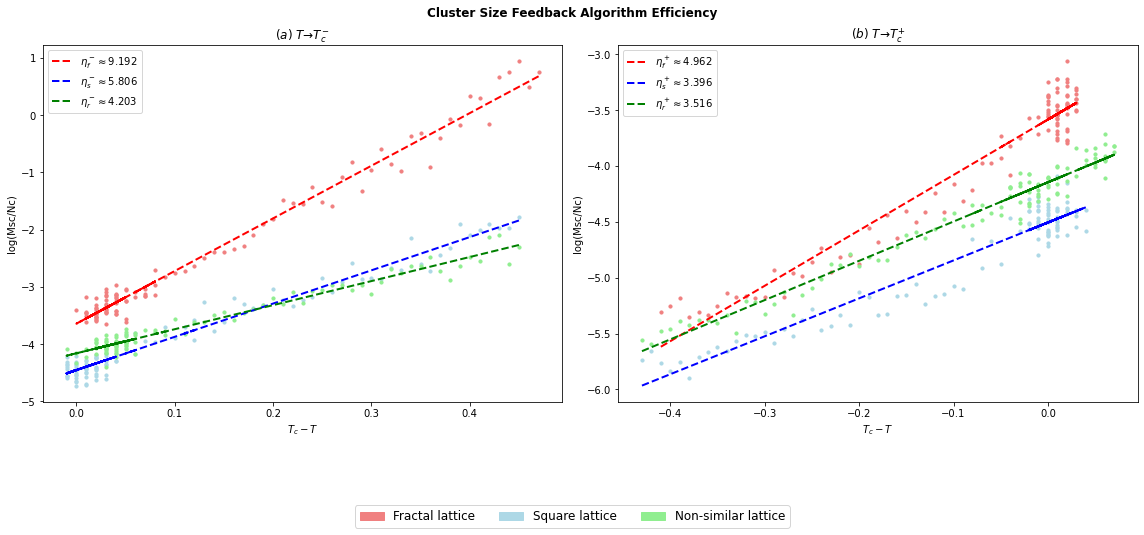

In [28]:
import matplotlib.patches as mpatches

# Create the figure with two subplots and larger size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Define colors for data points (lighter shades of regression colors)
data_colors = {
    'Fractal lattice': 'lightcoral',
    'Square lattice': 'lightblue',
    'Non-similar lattice': 'lightgreen'
}

coef1 = model1.coef_[0]
coef2 = model2.coef_[0]
coef3 = model3.coef_[0]

# Scatter plots for data points with adjusted colors in the first subplot
ax1.scatter(ts[0], np.log(np.array(msc_[0])/np.array(nc_[0])), color=data_colors['Fractal lattice'], s=10)
ax1.scatter(ts[1], np.log(np.array(msc_[1])/np.array(nc_[1])), color=data_colors['Square lattice'], s=10)
ax1.scatter(ts[2], np.log(np.array(msc_[2])/np.array(nc_[2])), color=data_colors['Non-similar lattice'], s=10)


# Regression lines in the first subplot
ax1.plot(x, model1.predict(x), c="red", linestyle='--', linewidth=2, label=r"$\eta_f^- \approx {:.3f}$".format(coef1))
ax1.plot(x2, model2.predict(x2), c="blue", linestyle='--', linewidth=2, label= r"$\eta_s^- \approx {:.3f}$".format(coef2))
ax1.plot(x3, model3.predict(x3), c="green", linestyle='--', linewidth=2, label= r"$\eta_r^- \approx {:.3f}$".format(coef3))

# Labels and legend in the first subplot
ax1.set_xlabel(r"$ T_c - T $")
ax1.set_ylabel("log(Msc/Nc)")
ax1.legend()
ax1.set_title(r'$(a)~ T \to T_c^{-}$')

coef1_ = model1_.coef_[0]
coef2_ = model2_.coef_[0]
coef3_ = model3_.coef_[0]

ax2.scatter(ts2[0], np.log(np.array(msc2_[0])/np.array(nc2_[0])), color=data_colors['Fractal lattice'], s=10)
ax2.scatter(ts2[1], np.log(np.array(msc2_[1])/np.array(nc2_[1])), color=data_colors['Square lattice'], s=10)
ax2.scatter(ts2[2], np.log(np.array(msc2_[2])/np.array(nc2_[2])), color=data_colors['Non-similar lattice'], s=10)

ax2.plot(x_, model1_.predict(x_), c="red", linestyle='--', linewidth=2, label=r"$\eta_f^+ \approx {:.3f}$".format(coef1_))
ax2.plot(x2_, model2_.predict(x2_), c="blue", linestyle='--', linewidth=2,  label= r"$\eta_s^+ \approx {:.3f}$".format(coef2_))
ax2.plot(x3_, model3_.predict(x3_), c="green", linestyle='--', linewidth=2, label= r"$\eta_r^+ \approx {:.3f}$".format(coef3_))

# Labels and legend in the second subplot
ax2.set_xlabel(r"$ T_c - T $")
ax2.set_ylabel("log(Msc/Nc)")
ax2.legend()
ax2.set_title(r'$(b)~ T \to T_c^{+}$')


# Create custom color patches for the legend
legend_patches = [mpatches.Patch(color=color, label=f'{label}') for label, color in data_colors.items()]

# Add legend with custom color patches outside subplots
fig.legend(handles=legend_patches, loc='lower center', ncol=len(data_colors), fontsize=12,
           bbox_to_anchor=(0.5, -0.2))  # Adjust the (x, y) position of the outside label

# Adjust subplot spacing
plt.tight_layout()
fig.suptitle(r"Cluster Size Feedback Algorithm Efficiency", y=1.02, fontweight='bold')
# Show the plot
plt.show()

# Some tests

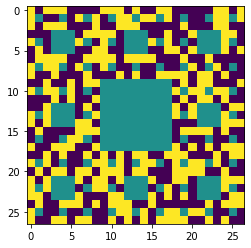

In [36]:
lattice1= flattice(3)
plt.imshow(lattice)

In [37]:
combined_metropolis_swendsen_wang(lattice1, 1.0, 0, 3, 1000000, 200)
clusters= swendsen_wang_step(lattice1, 0,3, 1.0, True)

In [40]:
from matplotlib.colors import ListedColormap
def plot_colored_points(grid, coordinates_list):
    # Create an empty grid for colors
    color_grid = np.full_like(grid, -1, dtype=np.float64)

    # Assign colors to the coordinates based on their index in the list
    for idx, coord_list in enumerate(coordinates_list):
        for x, y in coord_list:
            color_grid[x, y] = idx + 1

    # Find the maximum cluster index in the grid
    max_cluster_index = int(np.max(color_grid))

    # Create a custom colormap with unique colors for clusters and black for the background
    cmap = plt.cm.get_cmap('plasma', max_cluster_index + 1)
    cmap_colors = cmap.colors
    cmap_colors[0] = [1, 1, 1, 1]  # Set the first color to black for the background
    cmap_colors[1] = [209/255 ,140/255, 195/255, 1.0]
    custom_cmap = ListedColormap(cmap_colors)

    # Create a plot
    plt.figure(figsize=(8, 8))
    plt.imshow(color_grid, cmap=custom_cmap, interpolation='none', vmin=0, vmax=max_cluster_index)
    plt.colorbar(ticks=range(max_cluster_index + 1), label='Cluster')
    plt.title(r'Clusters at $T < T_c$')
    plt.show()

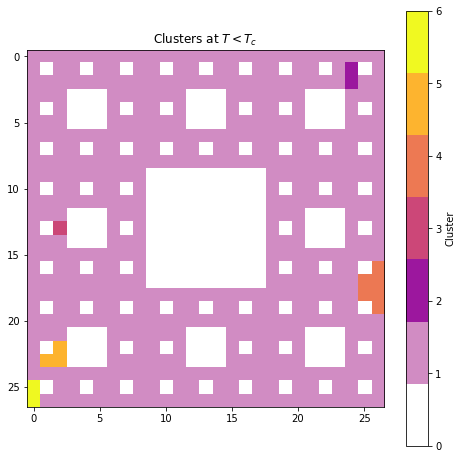

In [41]:
plot_colored_points(lattice1, clusters)